# Prediction: Tension Models
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from collections import OrderedDict
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, RecoilAsTension
from simgnn.transforms import AppendReversedEdges, AppendEdgeNorm, AppendEdgeLen, AppendDiff_x, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


### Datasets

---
- **Normalisation param-s**

In [5]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

**Input features and normalisation param-s (transforms)**

*change according to training conditions*

In [6]:
# Input features
window_size = 5
print(f'> Set features window size to --> {window_size}')

# Simulation dataset
Tnrm = {k: [Pos2Vec(scale=10*l_0[k]), ScaleVelocity(0.5*l_0[k]), ScaleTension(t_sd[k], shift=t_av[k])]
        for k in ['sim', 'single_distr_sims', 'unimodal_wbasetens_sims']}

# Hara ablation dataset
Tnrm['abln'] = [Pos2Vec(scale=10*l_0['abln']), ScaleVelocity(0.5*l_0['abln']),
                RecoilAsTension(), 
                #ScaleTension(t_sd['abln'], shift=t_av['abln'])
               ]

# Hara movie dataset
Tnrm['hara'] = [Pos2Vec(scale=10*l_0['hara']) , ScaleVelocity(0.5*l_0['hara'])]

# Node and Edge Feature Transforms
for k in Tnrm:
    # to undirected graph: add e_ji for all e_ij
    Tnrm[k].append(AppendReversedEdges())
    
    # Add edge features
    Tnrm[k].append(AppendDiff_x())
    Tnrm[k].append(AppendEdgeNorm())
    Tnrm[k].append(AppendEdgeLen(norm=True, scale=l_0[k])) # for edge masks
    
    # flatten  node features
    Tnrm[k].append(Reshape_x((-1,window_size*2)))
    
    Tnrm[k] = T.Compose(Tnrm[k])

> Set features window size to --> 5


In [7]:
Tnrm['sim']

Compose([
    Pos2Vec(norm=True, scale=10.0, cat=False, pos_noise=None, noise_args=[], noise_kwargs={}),
    ScaleVelocity(scale=0.5),
    ScaleTension(scale=0.63, shift=0.6),
    AppendReversedEdges(reverse_attr=True, reverse_tension=False, edge_id=True),
    AppendDiff_x(norm=True),
    AppendEdgeNorm(N_dim=2),
    AppendEdgeLen(keep_dir=False, aggr_edge_id=True, use_edge_attr=False, norm=True, scale=1.0),
    Reshape_x((-1, 10)),
])

**Load datasets**

- if a new `w` parameter is set, delete the older *processed* dataset files

In [8]:
!rm -dr simgnn_data/single_distr_sims/train/processed
!rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

In [9]:
hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnrm['abln'], smoothing=True, sma_lag_time=3)
hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'], smoothing=True, sma_lag_time=4)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
# rand base contractility
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['unimodal_wbasetens_sims']
                     )
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['unimodal_wbasetens_sims']
                         )

# w/o base contractility
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['single_distr_sims']
                     )
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['single_distr_sims']
                         )


datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2': sim2_val,
                 'hara' : hara,
                 'abln': hara_abln}
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'hara': 'Hara',
                'abln': 'Recoil'}

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [10]:
# k = 'val2'
# t = 15
# print('{}\n{} : {}\nsize:{}\n\nFrame {}:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),t,datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][t]),pos=dict(enumerate(datasets_dict[k][t].pos.numpy())), node_size=10)

## Load Trained Model

In [10]:
from simgnn.train import train_model, load_log, plot_losses

# from simgnn.nn import mlp, IndependentBlock, MessageBlock, dims_to_dict, Encode_Process_Decode
from simgnn.models import construct_simple_gnn, GraphEncoder, GraphDecoder, GraphProcessor

In [11]:
import simgnn.hardcoded as hcmodels # hardcoded models for testing and experimentation

In [12]:
# # # # # Load Saved Model:
# model_dir = './simgnn_data/saved_models/tension_test'
# model_fname = '07122021_202217_model_04122021_bs2w5'
# train_log = load_log(path.join(model_dir,
#                                '07122021_202217_model_04122021_bs2w5'+'_train_log.pkl'))

# net = hcmodels.get_model_04122021().to(device)
# net.load_state_dict(torch.load(path.join(model_dir, '07122021_202217_model_04122021_bs2w5'+'_net.pkl'),
#                                map_location=device))

In [13]:
model_dir = './simgnn_data/saved_models/'
model_fname = '17122021_091435_YesNrmYesDiffX_bs2w5'
train_log = load_log(path.join(model_dir, model_fname + '_train_log.pkl'))

net = hcmodels.get_model_YesNrmYesDiffX().to(device)
net.load_state_dict(torch.load(path.join(model_dir, model_fname + '_net.pkl'),
                               map_location=device))

<All keys matched successfully>

## Plot Predictions

In [14]:
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction
from simgnn.train import predict_abln_tension, predict_dataset_tension, predict_dataset

from scipy.stats import pearsonr

- train_loss_tot =0.20582094781894425;
- train_loss_y =0.004660113744023061;
- train_loss_T =0.2011608340749212;
- train_loss_P =0.0;
- val_loss_tot =0.5489792531243435;
- val_loss_y =0.004540478734990403;
- val_loss_T =0.5444387743893531;
- val_loss_P =0.0;
- val2_loss_tot =0.6147441847562171;
- val2_loss_y =0.004102828757347742;
- val2_loss_T =0.6106413559988694;
- val2_loss_P =0.0;
- hara_loss_tot =0.0013380401431792586;
- hara_loss_y =0.0013380401431792586;
- hara_loss_T =0.0;
- hara_loss_P =0.0;



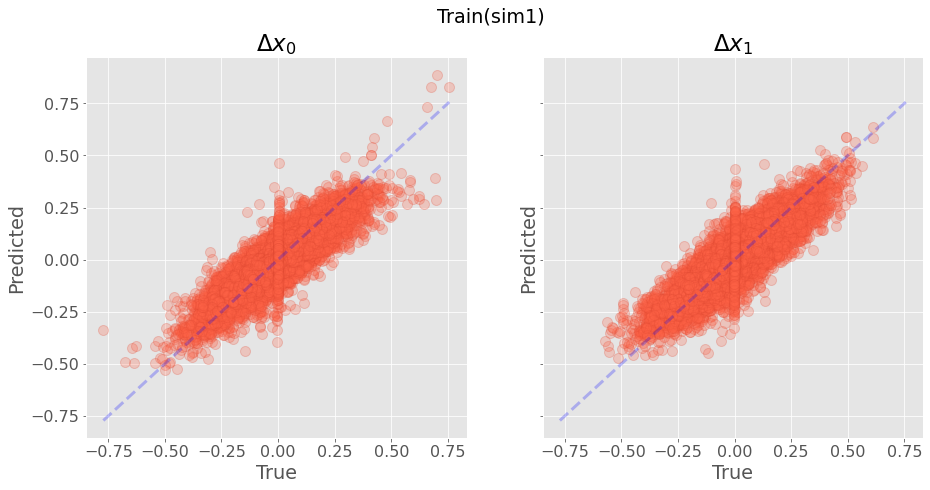

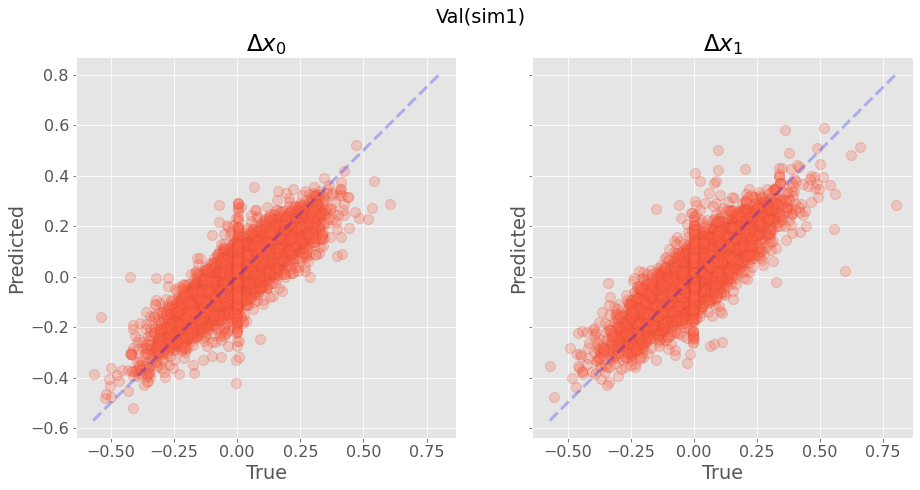

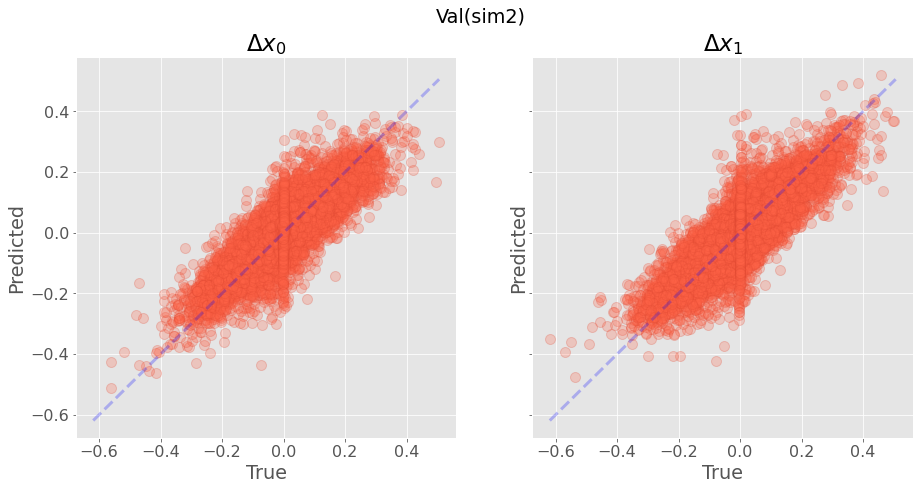

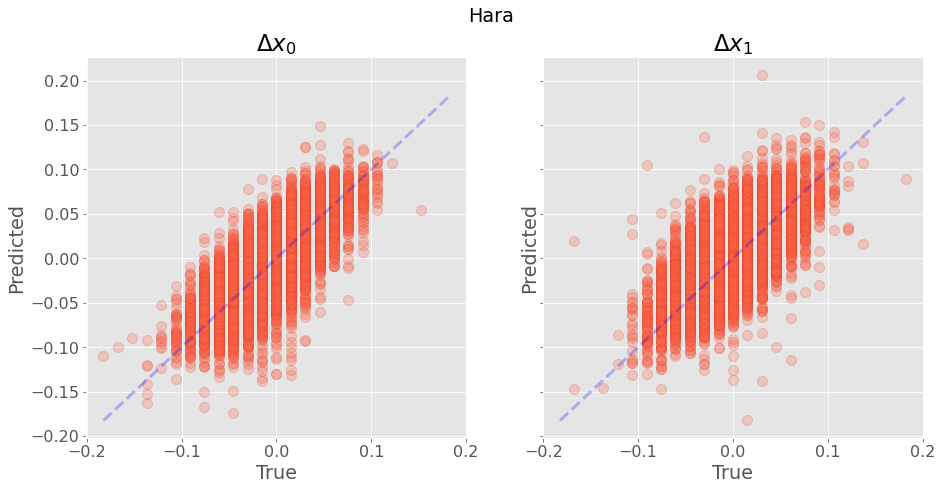

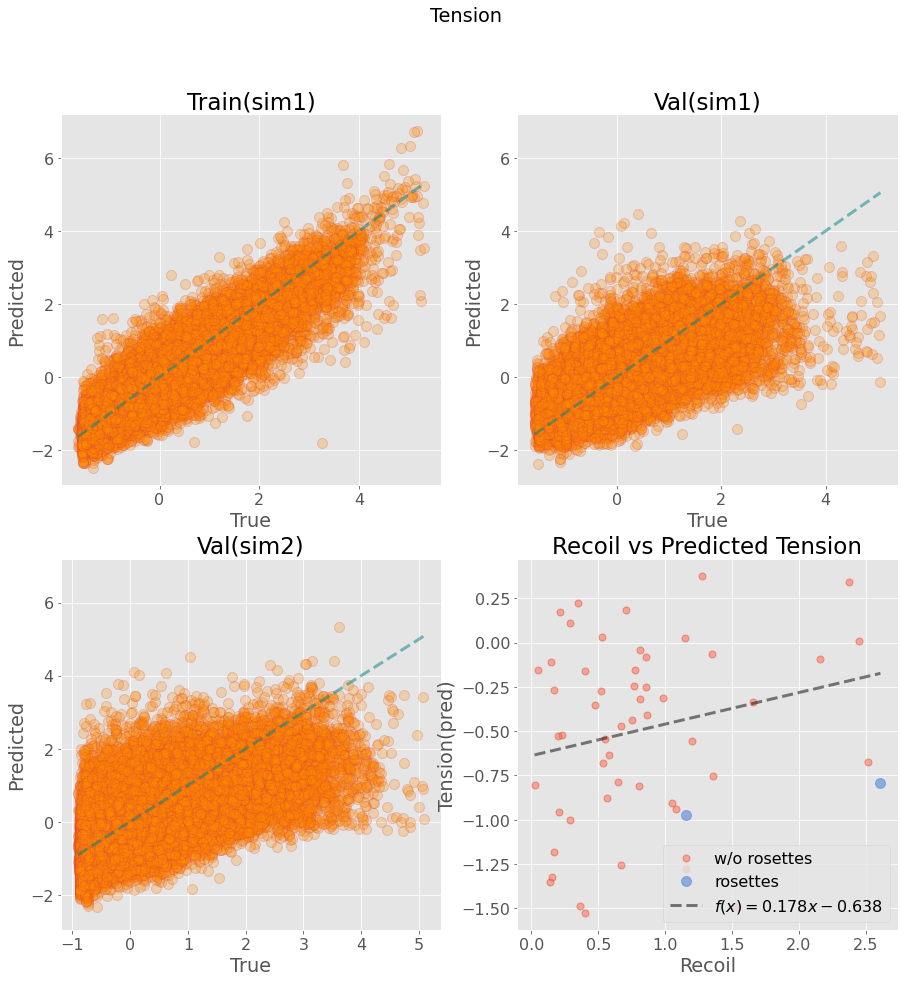

- - - - - - - - - - -
NO___rosettes : R,p=(0.2144706893588862, 0.12681017882302387)
WITH_rosettes : R,p=(0.15607048509539925, 0.2597568349156972)
- - - - - - - - - - -


In [15]:
# compute predictions and plot them
# vel-y, tens, pres
bs = 2

pred_out, tgt_out, sample_losses = predict_batch(net,
                                                 {
                                                  'train' : DataLoader(datasets_dict['train'], batch_size=bs),
                                                  'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
                                                  'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
                                                  'hara':   DataLoader(datasets_dict['hara'], batch_size=bs)},
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {'train': True, 'val': True, 'val2': True, 'hara': False},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

axs = plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend,figsize=[15,15],nrows=2,ncols=2)

# # # # # # # # # # # # # #
# # # Hara Ablation # # # #
# # # # # # # # # # # # # #
Tp, Tt, is_ros_ = predict_abln_tension(net, datasets_dict['abln'], device=device)

m1,m2 = np.polyfit(Tt[~is_ros_], Tp[~is_ros_], 1)
y_fit = np.array([min(Tt),max(Tt)])*m1+m2

# plt.figure(figsize=[6,6])
ax = axs.ravel()[-1]
ax.plot(Tt[~is_ros_], Tp[~is_ros_], 'o', mfc='tomato', ms=7, alpha=.5, label='w/o rosettes')
ax.plot(Tt[is_ros_], Tp[is_ros_], 'o', mfc='royalblue', ms=10, alpha=.5, label='rosettes')

ax.plot([min(Tt),max(Tt)], y_fit, 'k--',lw=3, alpha=.5, label=f'$f(x)={m1:.3f}x{"+" if m2>0 else "-"}{np.abs(m2):.3f}$')
ax.legend();
ax.set_title('Recoil vs Predicted Tension');
ax.set_xlabel('Recoil');
ax.set_ylabel('Tension(pred)');
ax.legend();

plt.show()
print('- '*10+'-')
print(f'NO___rosettes : R,p={pearsonr(Tt[~is_ros_], Tp[~is_ros_])}')
print(f'WITH_rosettes : R,p={pearsonr(Tt, Tp)}')
print('- '*10+'-')

---

**Check tension prediction, losses, and plots**

In [17]:
# Predict for each sample w/o batching:

tension_preds = {}
tension_tgts = {}
edge_lengths = {}

for dataset_k in ['train', 'val', 'val2']:
    Tp, Tt =  predict_dataset_tension(net, datasets_dict[dataset_k],device=device)
    edge_lengths[dataset_k] = [d.edge_length.numpy().reshape(1,-1) for d in datasets_dict[dataset_k]]
    tension_preds[dataset_k] = Tp
    tension_tgts[dataset_k] = Tt

In [18]:
# tension mask
ignore_short_edges, edge_len_threshold = True, 10**-4

for dataset_k in ['train', 'val', 'val2']:
    Tp = tension_preds[dataset_k]
    Tt = tension_tgts[dataset_k]
    edge_len = edge_lengths[dataset_k]
    
    print('-'*10+'\nTension losses:', end=' ')
    sum_l2_losses, Nsamples = np.array([(((Tp_k-Tt_k)**2).sum(), Tp_k.shape[1]) for Tp_k, Tt_k in zip(Tp, Tt)]).sum(axis=0)
    print(f'{dataset_k} MSE:', sum_l2_losses/Nsamples)
    
    print(f'with mask (Le>{edge_len_threshold:5.3g}):', end=' ')
    sum_l2_losses_mask, Nsamples_mask = np.array([(np.sum((Tp_k[Lij>edge_len_threshold]-Tt_k[Lij>edge_len_threshold])**2),
                                                   np.sum(Lij>edge_len_threshold))
                                                  for Tp_k, Tt_k, Lij in zip(Tp, Tt, edge_len)]).sum(axis=0)
    print(f'{dataset_k} MSE:', sum_l2_losses_mask/Nsamples_mask)

----------
Tension losses: train MSE: 0.2011608337827714
with mask (Le>0.0001): train MSE: 0.20113110232583745
----------
Tension losses: val MSE: 0.5444387763863444
with mask (Le>0.0001): val MSE: 0.5441750563278767
----------
Tension losses: val2 MSE: 0.6106413661955654
with mask (Le>0.0001): val2 MSE: 0.6088020123877467


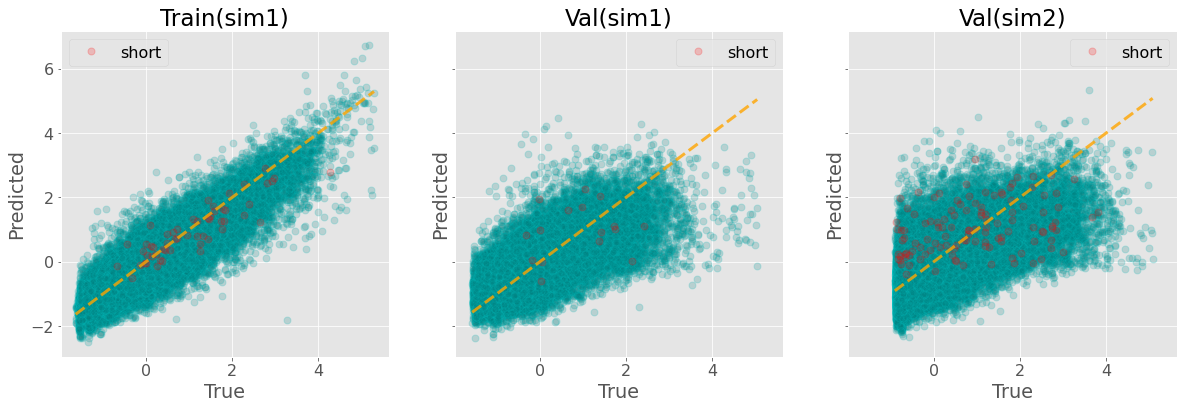

In [19]:
_, axs = plt.subplots(ncols=3, figsize=[20, 6], sharex=True, sharey=True)

for dataset_k, ax in zip(['train', 'val', 'val2'], axs):
    edge_len = edge_lengths[dataset_k]

    Tp = tension_preds[dataset_k]

    Tt = tension_tgts[dataset_k]

    # Plot target-vs-predcited
    minmaxY = [np.min(np.concatenate([k.ravel() for k in Tt])),
               np.max(np.concatenate([k.ravel() for k in Tt]))] 

    ax.plot(np.concatenate([Tt_k[L_k>edge_len_threshold].ravel() for Tt_k, L_k in zip(Tt, edge_len)]),
            np.concatenate([Tp_k[L_k>edge_len_threshold].ravel() for Tp_k, L_k in zip(Tp, edge_len)]),
            'o', ms=7, c='c', mfc='teal', alpha=.2)
    ax.plot(np.concatenate([Tt_k[L_k<=edge_len_threshold].ravel() for Tt_k, L_k in zip(Tt, edge_len)]),
            np.concatenate([Tp_k[L_k<=edge_len_threshold].ravel() for Tp_k, L_k in zip(Tp, edge_len)]),
            'o', ms=7, c='r', mfc='r', alpha=.2, label='short')
    ax.plot(minmaxY, minmaxY, '--', color='orange', lw=3, alpha=.8)
    ax.legend()
    ax.set_title(dataset_legend[dataset_k]);
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')

In [99]:
# dataset_k = 'train'

# l2_loss = torch.nn.MSELoss(reduction='mean')
# print('torch.nn.MSE:', l2_loss(torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_trues[dataset_k]])),
#                                torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_preds[dataset_k]]))) )

## Predictions vs True Tension Dynamics

### Simulation Datasets as Movies

In [54]:
dataset_mov_names = {}
dataset_mov_idx = {}
dataset_mov = {}

for dataset_k in ['val', 'val2', 'hara']: #  ['train', 'val', 'val2', 'hara']:
    print(dataset_k)

    d_names_list = [k.split('_')[2] for k in datasets_dict[dataset_k].processed_file_names]
    
    dataset_mov_names[dataset_k] = {k : ki for ki, k in enumerate(np.unique(d_names_list))}
    
    dataset_mov_idx[dataset_k] = torch.tensor([dataset_mov_names[dataset_k][k] for k in d_names_list])
    
    dataset_mov[dataset_k] = {k:datasets_dict[dataset_k][dataset_mov_names[dataset_k][k]==dataset_mov_idx[dataset_k]]
                              for k in dataset_mov_names[dataset_k]}
dataset_mov

val
val2
hara


{'val': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)},
 'val2': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)},
 'hara': {'001': HaraMovies(55), '003': HaraMovies(55), '005': HaraMovies(55)}}

### Model Predictions for Movies
> Predict `(Velocity[T+1], Tension[T])` for movies

In [55]:
from simgnn.train import np_loss_wrt_time, predict_abln_tension, predict_dataset_tension, predict_dataset

from scipy.stats import pearsonr

In [56]:
velocity_scale = {'train':1.1*.5, 'val':1.1*.5, 'val2':0.91*.5, 'hara':26.32*.5, 'abln':50.13*.5}

In [57]:
ignore_short_edges, edge_len_threshold = True, 10**-2

In [85]:
model_results = {}
loss_type = 'mse'

for dataset_k in dataset_mov:
    print('-'*10+'\n'+dataset_k)
    model_results[dataset_k] = {}
    for mov_i in dataset_mov[dataset_k]:
        print('\t',mov_i,f': len={len(dataset_mov[dataset_k][mov_i])};',
              f'E_n={torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id).size(0)};',
              f'V_n={dataset_mov[dataset_k][mov_i][0].num_nodes};',
              f'C_n={dataset_mov[dataset_k][mov_i][0].num_cells};', end=' ')

        model_results[dataset_k][mov_i] = predict_dataset(net, dataset_mov[dataset_k][mov_i],device=device, concat=True)
        
        edge_index = dataset_mov[dataset_k][mov_i][0].edge_index[:,torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id)]
        model_results[dataset_k][mov_i]['edge_index'] = edge_index
        
        pos = np.concatenate([d.pos.reshape(1,-1,2) for d in dataset_mov[dataset_k][mov_i]],axis=0)
        model_results[dataset_k][mov_i]['targets']['pos'] = pos
        
        edge_lengths = np.linalg.norm(pos[:, edge_index[1],:] - pos[:, edge_index[0],:], axis=-1)
        model_results[dataset_k][mov_i]['targets']['edge_lengths'] = edge_lengths
        
        dx_unnorm = velocity_scale[dataset_k]*model_results[dataset_k][mov_i]['predictions']['velocity']
        # pos predictions w/ velocity (except for first pos)
        pos_preds = np.concatenate([pos[:1],(pos+dx_unnorm)[:-1]], axis=0)
        model_results[dataset_k][mov_i]['predictions']['pos'] = pos_preds

        model_results[dataset_k][mov_i]['predictions']['edge_lengths'] = np.linalg.norm(pos_preds[:, edge_index[1],:] - pos_preds[:, edge_index[0],:], axis=-1)
        if ignore_short_edges:
            edge_mask = np.all(np.concatenate([dk.edge_length.numpy().reshape(1,-1)
                                               for dk in dataset_mov[dataset_k][mov_i]], axis=0) > edge_len_threshold, axis=0)
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = edge_mask
        else:
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = None
        
        model_results[dataset_k][mov_i]['loss'] = {}
        
        # velocity losses
        if len(model_results[dataset_k][mov_i]['targets']['velocity']) > 0:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['velocity'],
                                                                                   model_results[dataset_k][mov_i]['targets']['velocity'])
        else:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np.full((model_results[dataset_k][mov_i]['predictions']['velocity'].shape[1],), np.nan)
        
        # tension losses
        if len(model_results[dataset_k][mov_i]['targets']['tension']) > 0:
            model_results[dataset_k][mov_i]['loss']['tension'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['tension'],
                                                                                  model_results[dataset_k][mov_i]['targets']['tension'])
        else:
            model_results[dataset_k][mov_i]['loss']['tension'] = np.full((model_results[dataset_k][mov_i]['predictions']['tension'].shape[1],), np.nan)

        if ignore_short_edges:
            model_results[dataset_k][mov_i]['loss']['tension_mask'] = model_results[dataset_k][mov_i]['loss']['tension'].copy()
            model_results[dataset_k][mov_i]['loss']['tension_mask'][~edge_mask] = np.nan
        else:
            model_results[dataset_k][mov_i]['loss']['tension_mask'] = None
        model_results[dataset_k][mov_i]['loss']['edge_lengths'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['edge_lengths'],
                                                                                   model_results[dataset_k][mov_i]['targets']['edge_lengths'])
        
        print(f"Losses: Vel-y={np.nanmean(model_results[dataset_k][mov_i]['loss']['velocity']):6.4f}; "+
              f"E_len={np.nanmean(model_results[dataset_k][mov_i]['loss']['edge_lengths']):6.4f}; "+
              f"Tension={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension']):6.4f};"+
             f"Tension(mask)={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension_mask']) if ignore_short_edges else 0.0:6.4f}")

----------
val
	 sim005 : len=56; E_n=339; V_n=240; C_n=100; Losses: Vel-y=0.0041; E_len=0.0013; Tension=0.5145;Tension(mask)=0.3728
	 sim006 : len=56; E_n=275; V_n=196; C_n=80; Losses: Vel-y=0.0050; E_len=0.0015; Tension=0.5813;Tension(mask)=0.4207
----------
val2
	 sim005 : len=56; E_n=431; V_n=304; C_n=128; Losses: Vel-y=0.0044; E_len=0.0019; Tension=0.6328;Tension(mask)=0.3614
	 sim006 : len=56; E_n=531; V_n=372; C_n=160; Losses: Vel-y=0.0039; E_len=0.0016; Tension=0.5926;Tension(mask)=0.3572
----------
hara
	 001 : len=55; E_n=225; V_n=164; C_n=128; 

/Users/muratshagirov/miniconda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice
/Users/muratshagirov/miniconda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


Losses: Vel-y=0.0013; E_len=0.2023; Tension=   nan;Tension(mask)=   nan
	 003 : len=55; E_n=149; V_n=119; C_n=124; Losses: Vel-y=0.0013; E_len=0.1757; Tension=   nan;Tension(mask)=   nan
	 005 : len=55; E_n=164; V_n=130; C_n=114; Losses: Vel-y=0.0014; E_len=0.2332; Tension=   nan;Tension(mask)=   nan


### Plot Edge Length and Node Dynamics

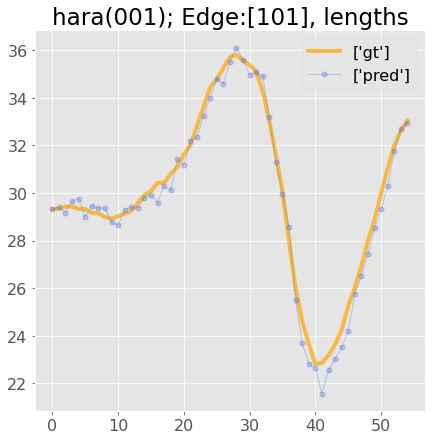

In [98]:
dataset_k = 'hara'  # ['val2']['sim005']
mov_i = '001'
# Lij = model_results['targets']['edge_lengths']
# Lij_p = model_results['val2']['sim005']['predictions']['edge_lengths']
Lij = model_results[dataset_k][mov_i]['targets']['edge_lengths']
Lij_p = model_results[dataset_k][mov_i]['predictions']['edge_lengths']

k=[101]
plt.figure(figsize=[7,7])
plt.plot(Lij[:,k], '-', c='orange', lw=4, alpha=.7,label=['gt']+[None for ki in k[1:]])
plt.plot(Lij_p[:,k], '-o',c='royalblue', lw=1, ms=5, alpha=.3, label=['pred']+[None for ki in k[1:]]);
plt.title(f'{dataset_k}({mov_i}); Edge:{k}, lengths')
plt.legend();

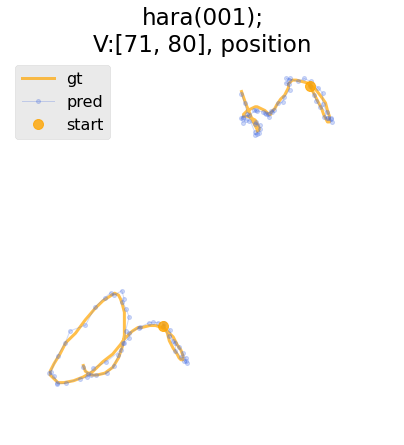

In [110]:
pos = model_results[dataset_k][mov_i]['targets']['pos']
pos_p = model_results[dataset_k][mov_i]['predictions']['pos']

e_st = model_results[dataset_k][mov_i]['edge_index'][:,k]
e_st_list = e_st.ravel().tolist()
plt.figure(figsize=[7,7])
plt.plot(pos[:,e_st_list,0],pos[:,e_st_list,1], '-', c='orange', lw=3, alpha=.7,label=['gt']+[None for k in range(len(e_st_list)-1)])
plt.plot(pos_p[:,e_st_list,0],pos_p[:,e_st_list,1], 'o-',c='royalblue', ms=4, lw=1, alpha=.25, label=['pred']+[None for k in range(len(e_st_list)-1)]);

plt.plot(pos[0,e_st_list,0],pos[0,e_st_list,1], 'o', c='orange', ms=10, alpha=.8,label='start')
# for e_k in range(e_st.shape[1]):
#     plt.plot(pos[-1,e_st[:,e_k],0],pos[-1,e_st[:,e_k],1], '-', c='orange', lw=4, alpha=.5)
#     plt.plot(pos_p[-1,e_st[:,e_k],0],pos_p[-1,e_st[:,e_k],1], '-',c='navy', lw=4, alpha=.4);
plt.title(f'{dataset_k}({mov_i});\nV:{e_st_list}, position')
plt.xlim([340, 380])
plt.ylim([240, 200])
plt.axis(False)
plt.legend();

### Predicted Dynamics

In [57]:
# ['train', 'val', 'val2']['movie_1',...,'movie_N']['predictions', 'targets', 'edge_index']

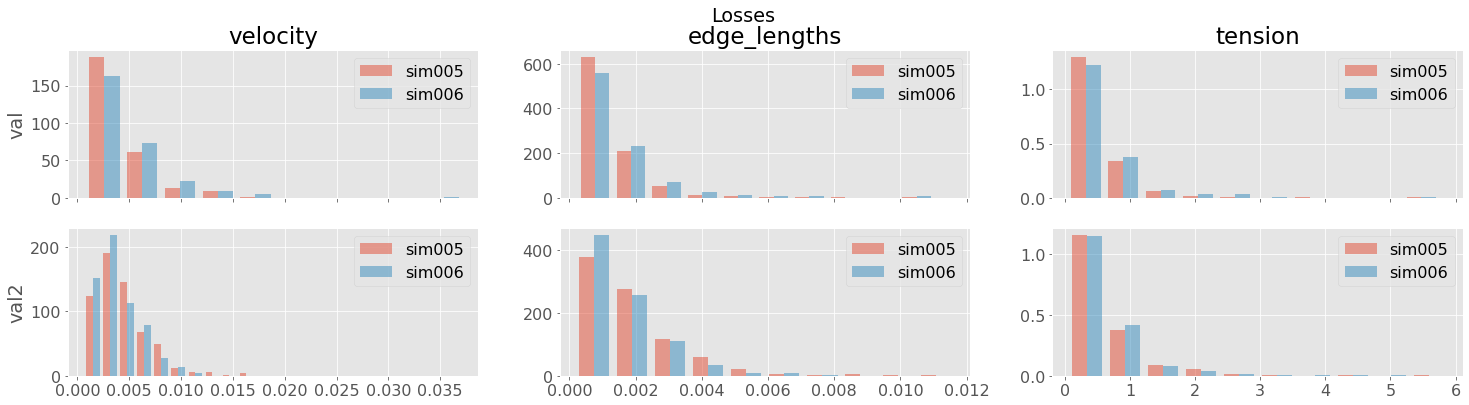

In [28]:
dataset_names = ['val', 'val2'] # list(model_results.keys())

fig, axs = plt.subplots(nrows=len(dataset_names), ncols=3, figsize=[25,1+2.5*len(dataset_names)], sharex='col')

dataset_var_minmax = {}

for dataset_k, ax_k in zip(dataset_names, axs): #zip(, axs):
    dataset_var_minmax[dataset_k] = {}
    for k, var_k in enumerate(['velocity', 'edge_lengths', 'tension']):
        dataset_var_minmax[dataset_k][var_k] = np.array([[np.quantile(model_results[dataset_k][mov_k]['targets'][var_k], 0.01),
                                                          np.quantile(model_results[dataset_k][mov_k]['targets'][var_k], 0.995)]
                                                         for mov_k in model_results[dataset_k]])
        dataset_var_minmax[dataset_k][var_k] = [dataset_var_minmax[dataset_k][var_k][:,0].min(), dataset_var_minmax[dataset_k][var_k][:,1].max()]

        ax_k[k].hist([model_results[dataset_k][mov_k]['loss'][var_k] for mov_k in model_results[dataset_k]],
                     label=[mov_k for mov_k in model_results[dataset_k]], alpha=.5, density=True, stacked=False)
        ax_k[k].legend()
        if dataset_k==dataset_names[0]:
            ax_k[k].set_title(f'{var_k}')
    ax_k[0].set_ylabel(f'{dataset_k}')
plt.suptitle('Losses')
plt.show()

var_limits = {k:np.array([dataset_var_minmax[k_up][k] for k_up in dataset_var_minmax]) for k in ['velocity', 'edge_lengths', 'tension']}
var_limits = {var_k:[var_limits[var_k][:,0].min(), var_limits[var_k][:,1].max()] for var_k in var_limits}

In [30]:
var_limits

{'velocity': [-0.2617666506767273, 0.3144946208596225],
 'edge_lengths': [0.0004144500286201947, 3.003029745817185],
 'tension': [-1.4892891240119934, 3.707299780845643]}

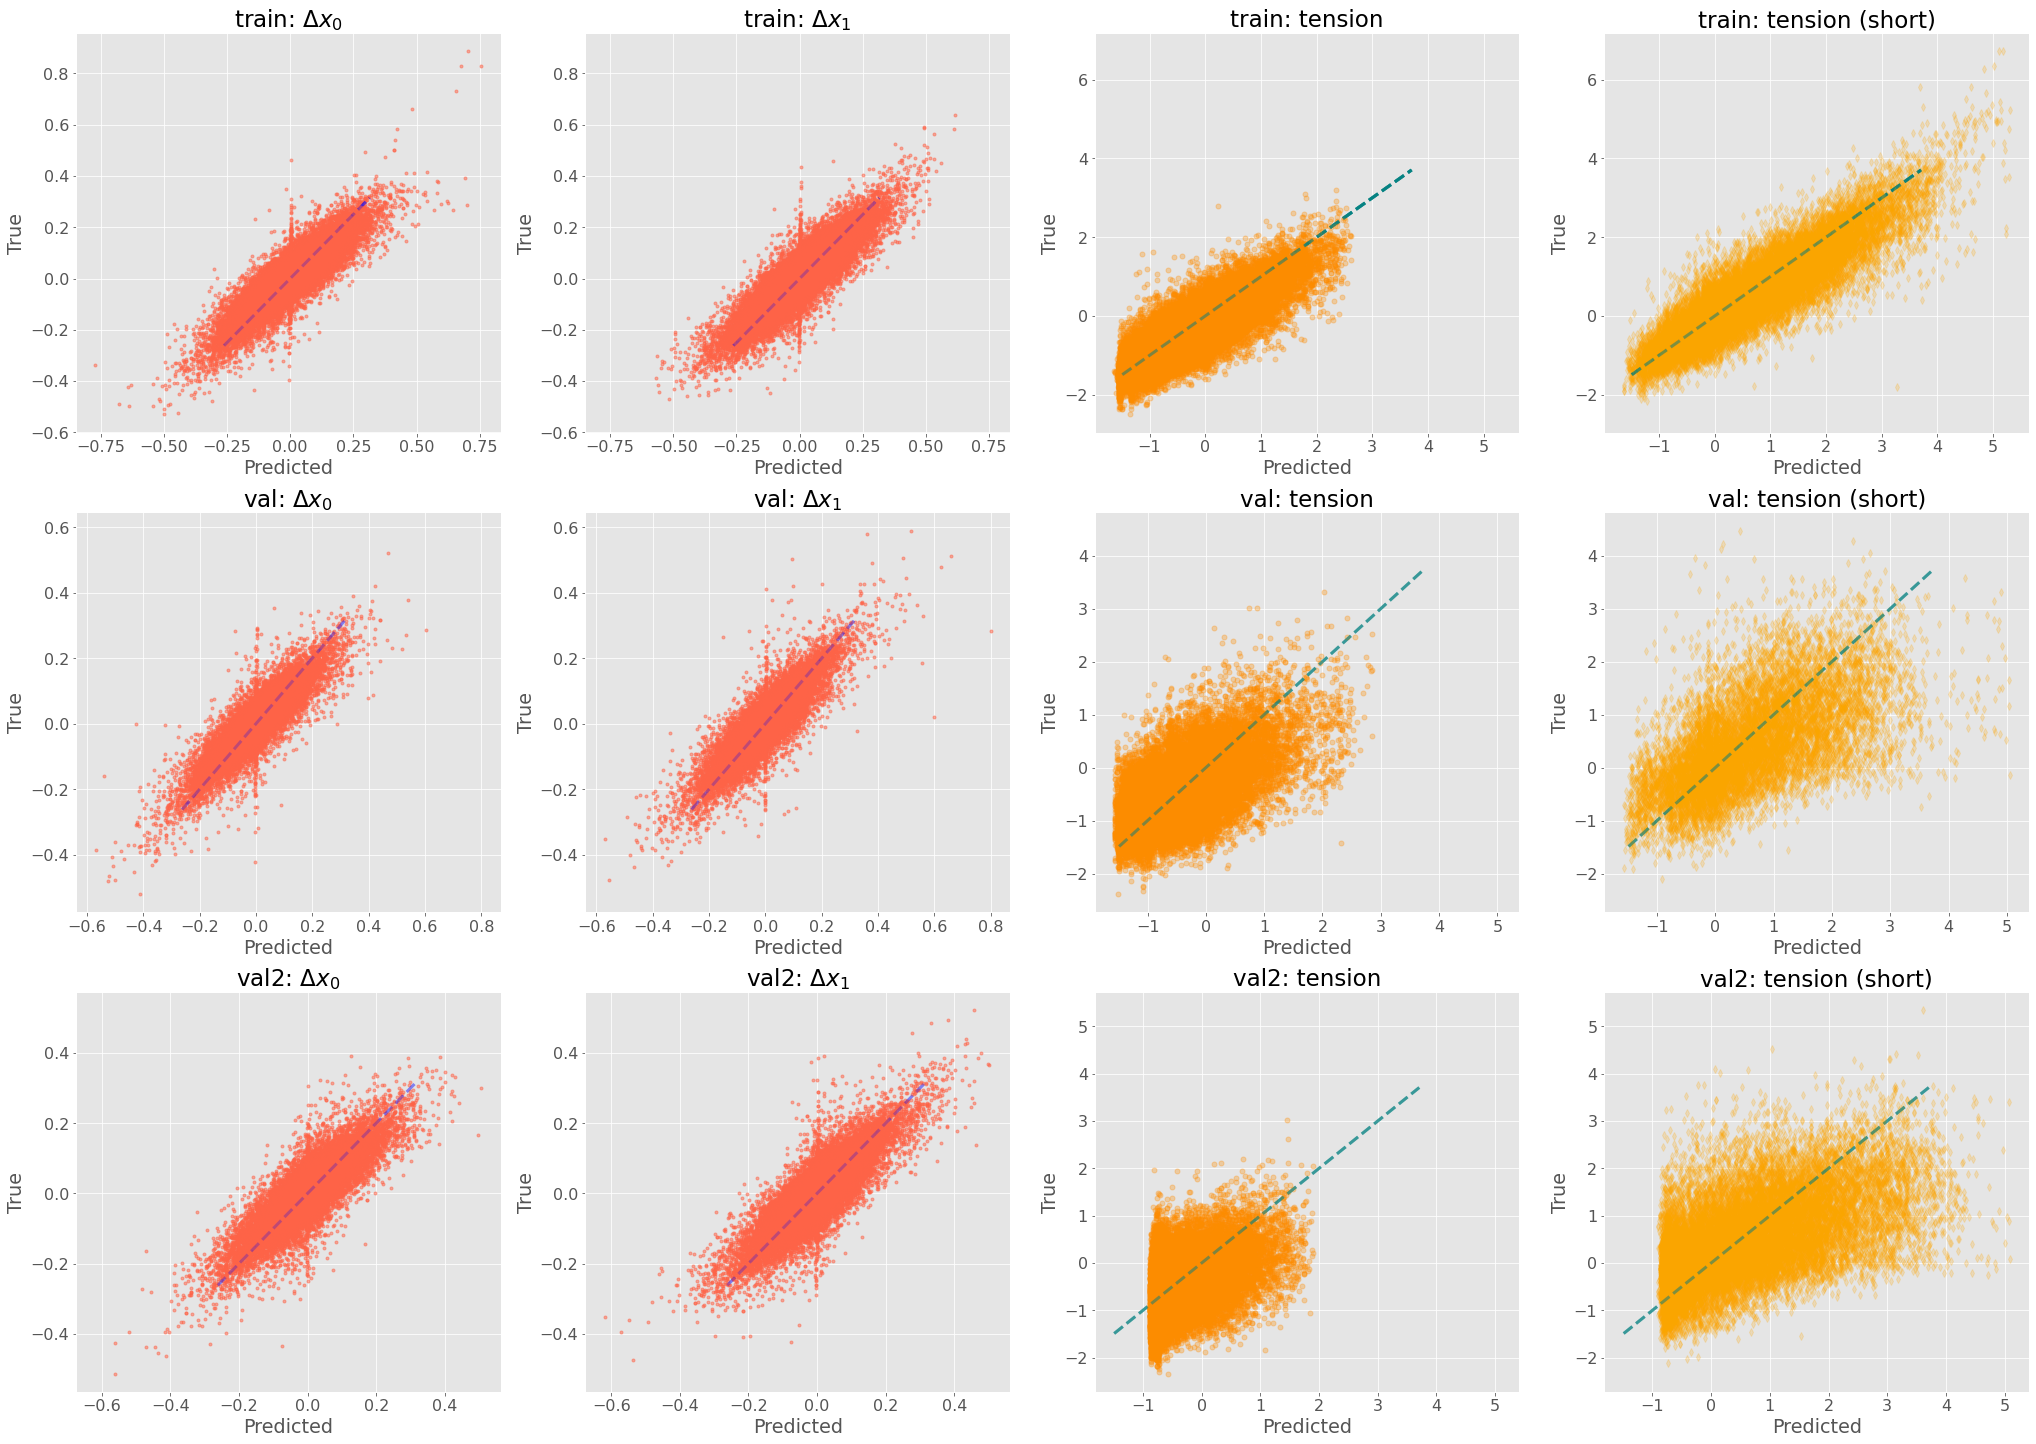

In [36]:
fig, axs = plt.subplots(nrows=len(model_results), ncols=4, figsize=[35,25])
for dataset_k, ax_k in zip(model_results, axs):
    for mov_n in model_results[dataset_k]:
        ax_k[0].plot(model_results[dataset_k][mov_n]['targets']['velocity'][:,:,0].ravel(),
                     model_results[dataset_k][mov_n]['predictions']['velocity'][:,:,0].ravel(), 'o',
                     # label=mov_n,
                     c='tomato',
                     ms=3, alpha=.5)
        ax_k[0].set_ylabel('True')
        ax_k[0].set_xlabel('Predicted')
        ax_k[0].set_title(f'{dataset_k}: '+r'$\Delta{}x_0$')
        ax_k[0].plot(var_limits['velocity'], var_limits['velocity'], '--', color='b', lw=3, alpha=.25)
        
        ax_k[1].plot(model_results[dataset_k][mov_n]['targets']['velocity'][:,:,1].ravel(),
                     model_results[dataset_k][mov_n]['predictions']['velocity'][:,:,1].ravel(), 'o',
                     # label=mov_n,
                     c='tomato',
                     ms=3, alpha=.5)
        ax_k[1].set_ylabel('True')
        ax_k[1].set_xlabel('Predicted')
        ax_k[1].set_title(f'{dataset_k}: '+r'$\Delta{}x_1$')
        ax_k[1].sharex(ax_k[0])
        ax_k[1].sharey(ax_k[0])
        ax_k[1].plot(var_limits['velocity'], var_limits['velocity'], '--', color='b', lw=3, alpha=.25)
        
        edge_masks = model_results[dataset_k][mov_n]['predictions']['edge_masks']
        
        ax_k[2].plot(model_results[dataset_k][mov_n]['targets']['tension'][:,edge_masks].ravel(),
                     model_results[dataset_k][mov_n]['predictions']['tension'][:,edge_masks].ravel(), 'o',
                     # label=mov_n,
                     c='darkorange',
                     ms=5, alpha=.3)
        ax_k[2].set_ylabel('True')
        ax_k[2].set_xlabel('Predicted')
        ax_k[2].set_title(f'{dataset_k}: tension')
        ax_k[2].plot(var_limits['tension'], var_limits['tension'], '--', color='teal', lw=3, alpha=.5)
        
        ax_k[3].plot(model_results[dataset_k][mov_n]['targets']['tension'][:,~edge_masks].ravel(),
                     model_results[dataset_k][mov_n]['predictions']['tension'][:,~edge_masks].ravel(), 'd',
                     # label=mov_n,
                     c='orange',
                     ms=5, alpha=.2)
        
        ax_k[3].set_ylabel('True')
        ax_k[3].set_xlabel('Predicted')
        ax_k[3].set_title(f'{dataset_k}: tension (short)')
        ax_k[3].plot(var_limits['tension'], var_limits['tension'], '--', color='teal', lw=3, alpha=.5)
        ax_k[3].sharex(ax_k[2])
        ax_k[3].sharey(ax_k[2])
        
    # ax_k[0].legend()
    # ax_k[1].legend()
    # ax_k[2].legend()

**Select edges based on trajectopry errors:**

In [38]:
# edge ids for selected loss thresholds
tension_errors_model = {dataname_k:{} for dataname_k in ['val', 'val2']}
for dataname_k in ['val', 'val2']:
    print(dataname_k, ':')
    for mov_k in model_results[dataname_k]:
        tension_errors_model[dataname_k][mov_k] = (model_results[dataname_k][mov_k]['loss']['tension']>2).nonzero()[0]
        print('  ',mov_k, ':', tension_errors_model[dataname_k][mov_k])

val :
   sim005 : [ 19  28  29  65  91 121 325]
   sim006 : [ 17  25  99 115 145 215 234 256]
val2 :
   sim005 : [ 53  87  92 105 133 139 195 196 199 201 261 276 280 352 371 419 425 428
 430]
   sim006 : [ 21  55 124 130 159 190 207 221 242 289 295 343 370 384 425 483]


In [40]:
# edge ids for selected loss >2 for model:"07122021_202217_model_04122021_bs2w5"
tension_errors = {'val': {'sim005': [19, 65, 91, 121, 214, 237, 325],
                          'sim006': [17, 25, 99, 115, 137, 145, 215, 256]},
                  'val2':{'sim005': [53, 73, 87, 92, 97, 105, 133, 139, 196, 199, 261, 280, 344, 352, 371, 404, 419, 425],
                          'sim006': [21, 55, 67, 89, 159, 190, 207, 221, 242, 289, 295, 343, 370, 380, 384, 445, 483]}
                 }

In [41]:
# tension_errors = tension_errors_model

In [ ]:
np.random.seed(0)
for dataname_k in tension_errors:
    for mov_k in tension_errors[dataname_k]:
        print('-'*10+'\n',f'{dataname_k}:{mov_k}\n')
        N_plots = min([3*(len(tension_errors[dataname_k][mov_k])//3), 15])
        
        e_ids = np.sort(np.random.choice(tension_errors[dataname_k][mov_k], size=(N_plots,), replace=False))
        
        fig, axs = plt.subplots(nrows=N_plots//3, ncols=3, figsize=[20, 6*(N_plots//3)+1], gridspec_kw={'wspace':.5, 'hspace':.5})

        for k, ax in zip(e_ids, axs.ravel()):
            # Edge tensions
            Te_tgt = model_results[dataname_k][mov_k]['targets']['tension'][:,k]
            Te_pred = model_results[dataname_k][mov_k]['predictions']['tension'][:,k]
            Te_loss = model_results[dataname_k][mov_k]['loss']['tension'][k] # Tension pred-n loss
            # Edge lengths
            Le_tgt = model_results[dataname_k][mov_k]['targets']['edge_lengths'][:,k]
            Le_pred = model_results[dataname_k][mov_k]['predictions']['edge_lengths'][:,k]
            
            p1, = ax.plot(Te_tgt, '--', c='royalblue', alpha=0.7, lw=3, label=r'$T_{tgt}$')
            ax.plot(Te_pred, c='teal', alpha=0.4, lw=3, label=r'$T_{pred}$')
            
            ax2 = ax.twinx()
            p2, = ax2.plot(Le_tgt, c='crimson', alpha=0.7, lw=3, label=r'$L_{tgt}$')
            ax2.plot(Le_pred, c='darkorange', alpha=0.7, lw=3, label=r'$L_{pred}$')
            
            ax.set_xlabel(f'Frames (edge {k})', fontsize=12)
            ax.set_title(f'MSE_t={Te_loss:.3f}', fontsize=12)
            ax.set_ylabel(r'Tension', color=p1.get_color())
            ax.tick_params(axis='y', labelcolor=p1.get_color())
            ax.set_ylim(var_limits['tension'][0], var_limits['tension'][1])
            
            ax2.set_ylabel(r'Edge Length', color=p2.get_color())
            ax2.tick_params(axis='y', labelcolor=p2.get_color())
            ax2.set_ylim(var_limits['edge_lengths'][0], var_limits['edge_lengths'][1])
            
            ax2.legend(loc='upper right')
            ax.legend(loc='upper left')
        plt.suptitle(f'{dataname_k}:{mov_k}', fontsize=15, y=0.93)
        # plt.savefig(f'./{dataname_k}_{mov_k}_tension_dynamics_prediction_LOW_error.png',dpi=100, bbox_inches="tight")
        plt.show()
        plt.close()

### Cross-correlations

In [37]:
def lagged_xcorr(x1,x2):
    '''"Lagged correlation",
    ouput:
    - lags, xcorr : lag times, and corresponding xcorr values
    xcorr val-s are devided by x1.shape[0] (produces average), and np.std(x1)*np.std(x2) (scale to normalize xcorr)
    '''
    assert x1.shape[0]==x2.shape[0]
    xcorr_scale = np.std(x1)*np.std(x2)
    # "full" xcorr will be "2 * x1.shape[0] -1", middle is lag==0
    xcorr = np.correlate(x1,x2,mode='full') /xcorr_scale /x1.shape[0]

    lags = np.concatenate(( np.arange(-(x1.shape[0]-1),1), np.arange(1,x1.shape[0]) ) )
    return lags, xcorr

In [41]:
53  87  92 105 133 139 195 196 199 201 261 276 280 352 371 419 425 428
 430

(56, 339)

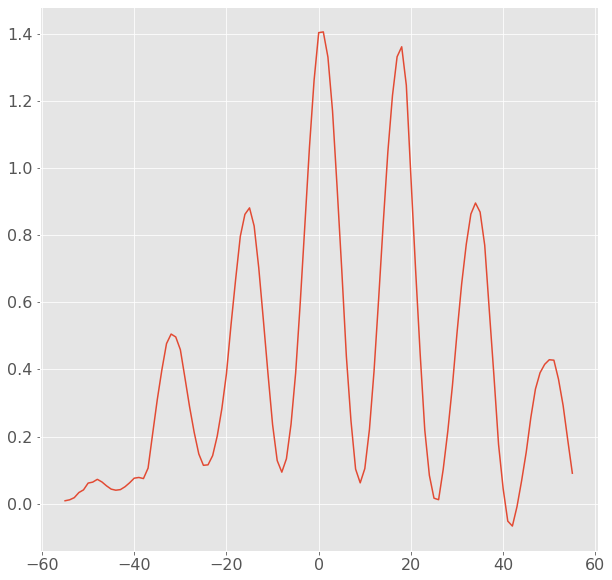

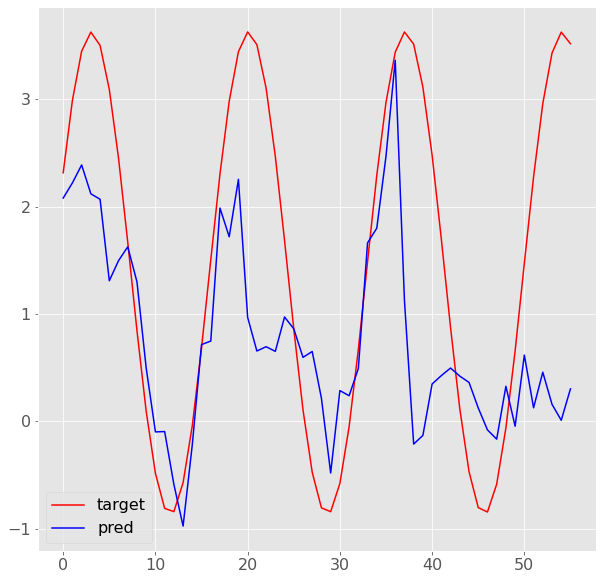

In [78]:
t = 280
dataname_k = 'val2'
mov_i = 'sim005'

lags, xcorr = lagged_xcorr(model_results[dataname_k][mov_i]['targets']['tension'][:, t],
                                       model_results[dataname_k][mov_i]['predictions']['tension'][:, t])
plt.plot(lags, xcorr)
plt.show()
plt.plot(model_results[dataname_k][mov_i]['targets']['tension'][:, t], 'r', label='target')
plt.plot(model_results[dataname_k][mov_i]['predictions']['tension'][:, t], 'b', label='pred')
plt.legend()
plt.show()

train : sim000 0.30357142857142855 3.116314460436645
train : sim001 1.2321428571428572 7.0254411946575885
train : sim002 -0.21428571428571427 0.6998542122237652
train : sim003 -0.5357142857142857 2.809195904997204
train : sim004 0.05357142857142857 6.206044412095191


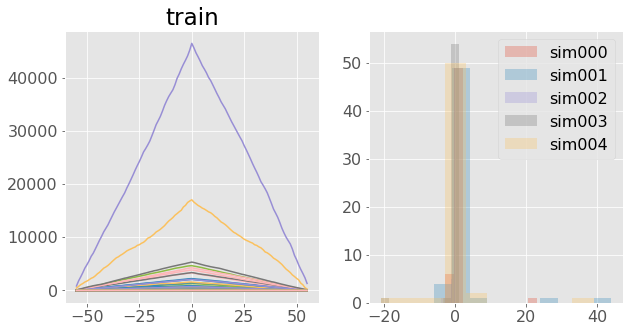

val : sim005 1.3392857142857142 6.970029682541546
val : sim006 2.732142857142857 12.73281905637746


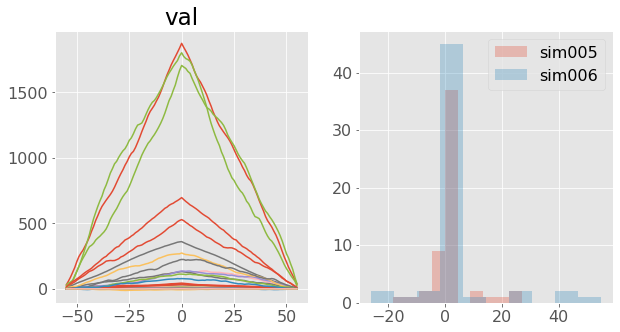

val2 : sim005 0.2857142857142857 7.743002107235479
val2 : sim006 -0.4107142857142857 8.891763415242954


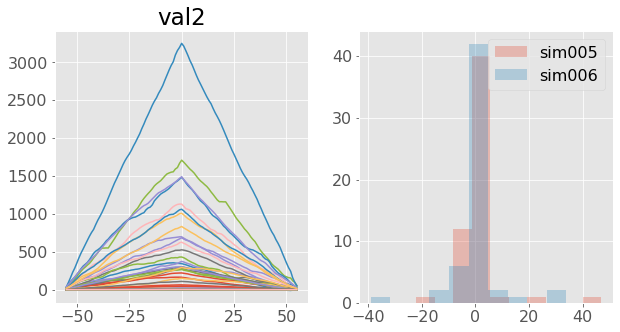

In [61]:
for dataname_k in model_results:
    fig, axs = plt.subplots(ncols=2, figsize=[10,5])
    for mov_i in  model_results[dataname_k]:
        lag_list = []
        for t in range(model_results[dataname_k][mov_i]['targets']['tension'].shape[0]):
            lags, xcorr = lagged_xcorr(model_results[dataname_k][mov_i]['targets']['tension'][:, t],
                                       model_results[dataname_k][mov_i]['predictions']['tension'][:, t])
            axs[0].plot(lags, xcorr)
            
            lag_list.append(lags[xcorr.argmax()])
        print(dataname_k,':', mov_i, np.mean(lag_list), np.std(lag_list))
        axs[1].hist(lag_list, label=mov_i, alpha=.3)
    axs[0].set_title(dataname_k)
    axs[1].legend()
    plt.show()